# Step 1 : importing Essential Libraries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


In [5]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:


skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [7]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [8]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [9]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [10]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [11]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


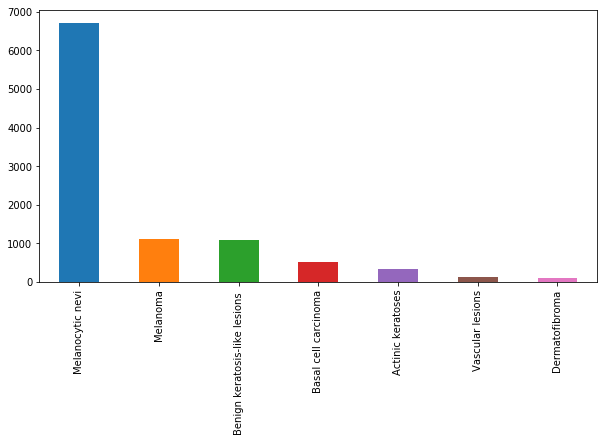

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

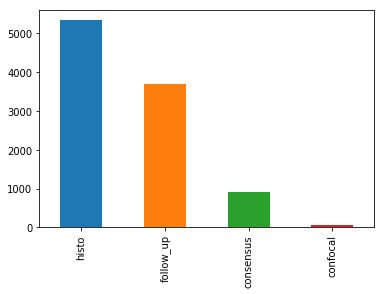

In [13]:
skin_df['dx_type'].value_counts().plot(kind='bar')

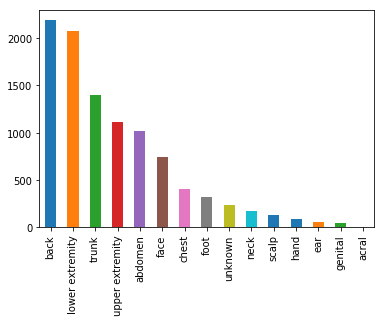

In [14]:
skin_df['localization'].value_counts().plot(kind='bar')

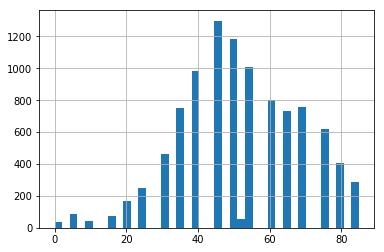

In [15]:
skin_df['age'].hist(bins=40)

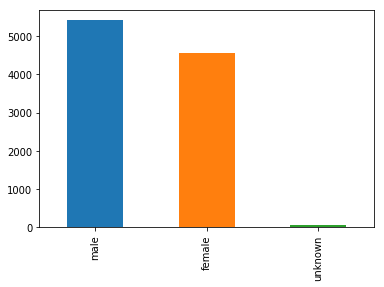

In [16]:

skin_df['sex'].value_counts().plot(kind='bar')

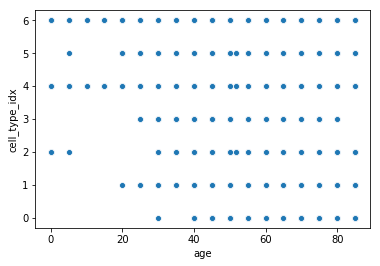

In [17]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

Sexwise distribution of skin cancer type

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


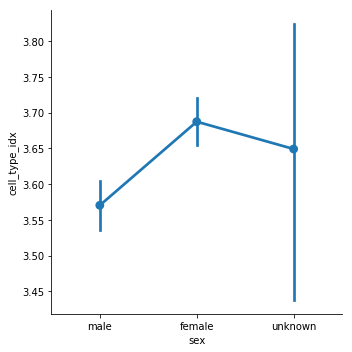

In [18]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

In [19]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [20]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


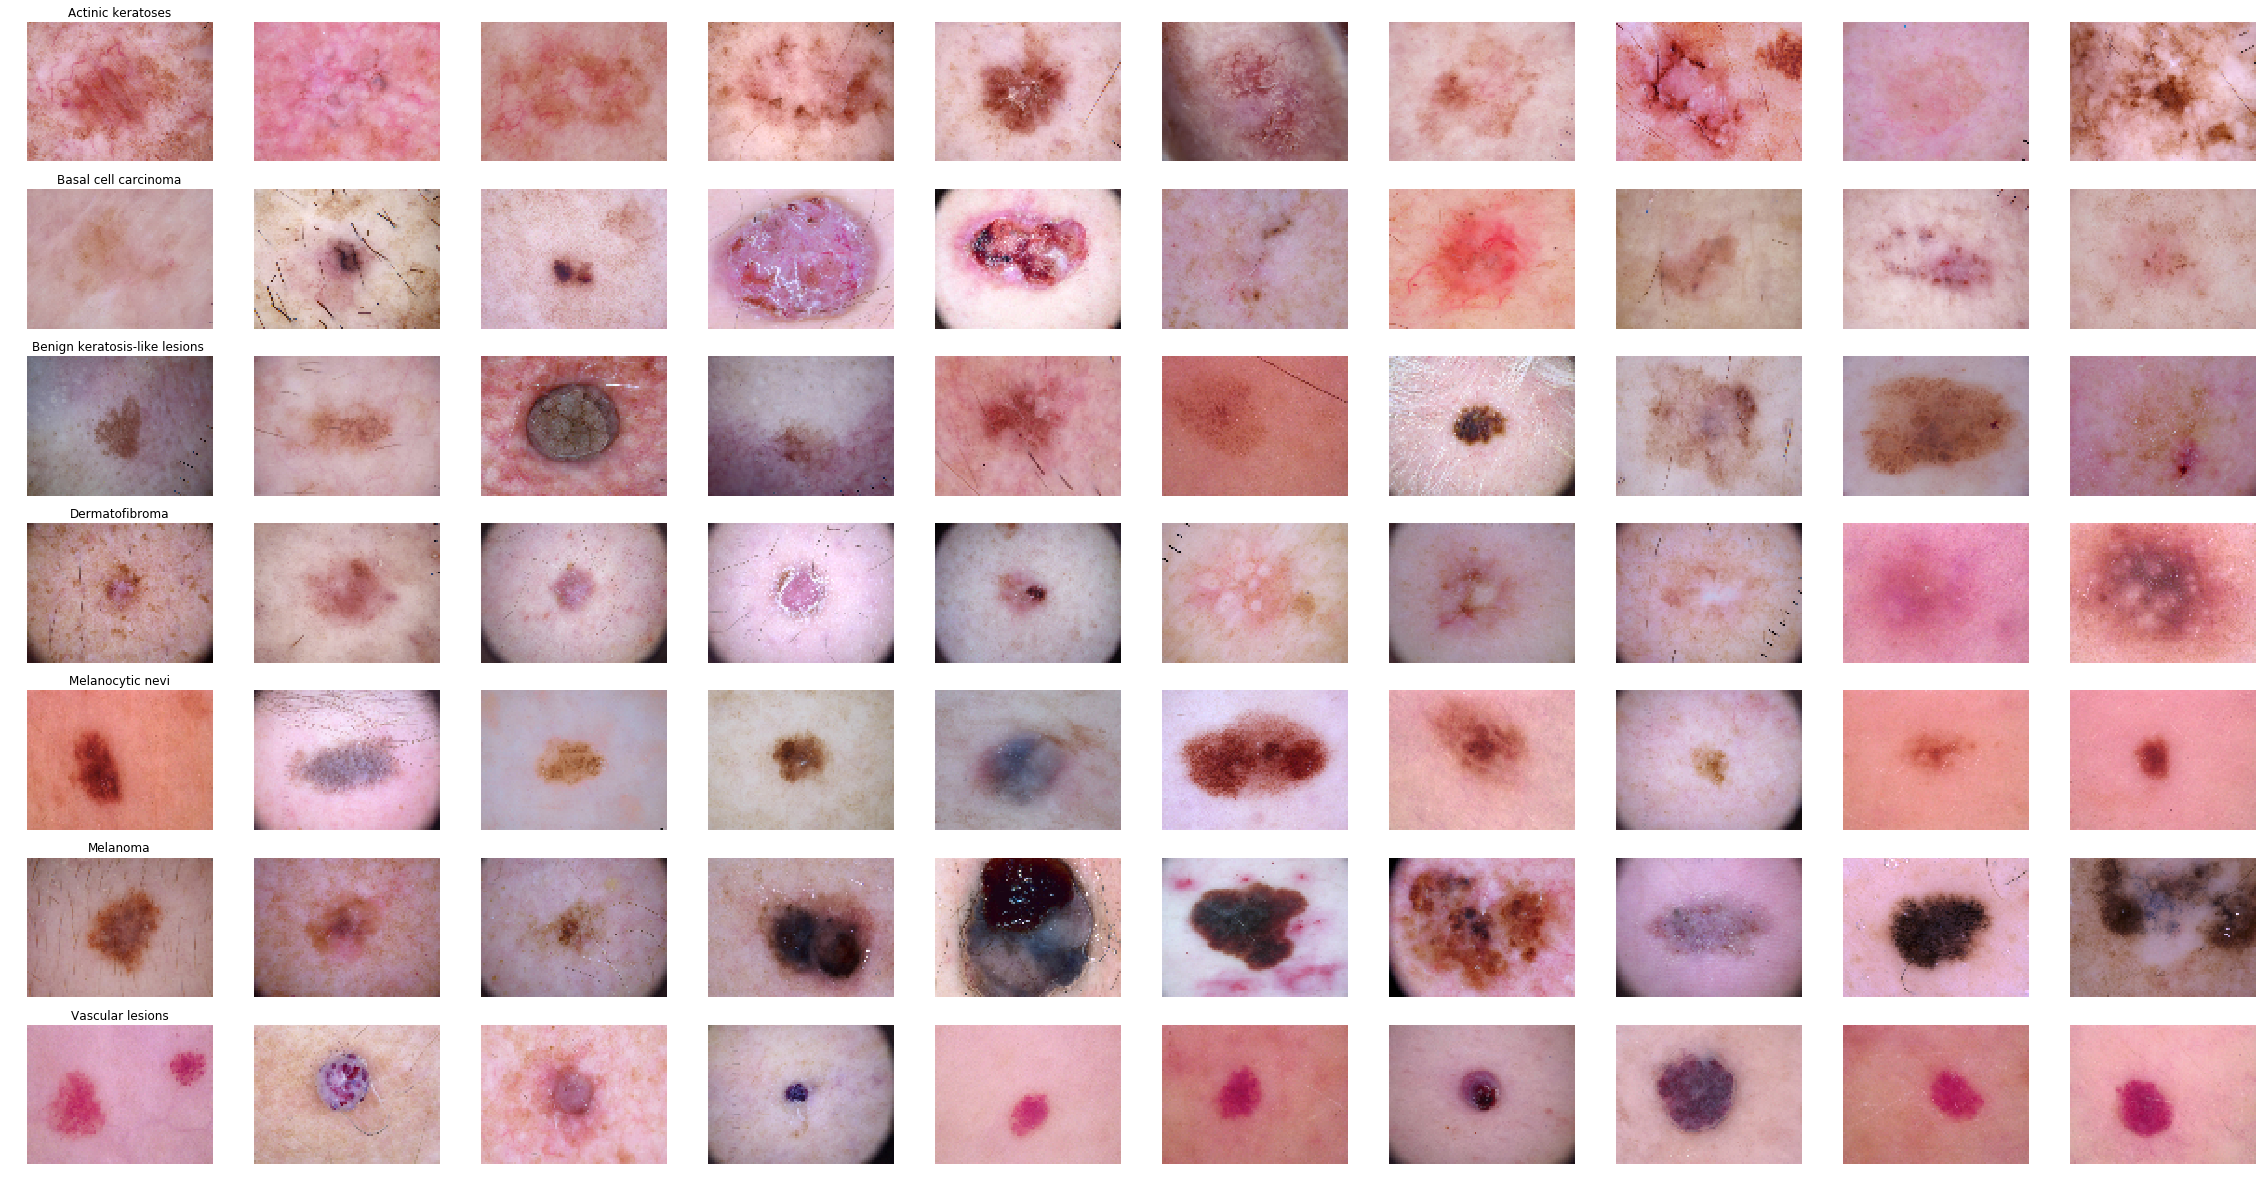

In [21]:
n_samples = 10
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [22]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [23]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [24]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# Step 8 : Normalization

In [25]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [26]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [27]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [28]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [29]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
# input_shape = (75, 100, 3)
# num_classes = 7

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.40))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

In [30]:
input_shape = (75, 100, 3)
num_classes = 7

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(75,100,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(7))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))
# AlexNet.add(Dense(num_classes, activation='softmax'))

#Model Summary
AlexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 19, 25, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 25, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 19, 25, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 13, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 13, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 13, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 13, 256)       0         
__________

In [31]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [32]:
# Compile the model
AlexNet.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [33]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [34]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)


In [35]:
# Fit the model
epochs = 10
batch_size = 64
history = AlexNet.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
112/112 [==============================] - 20s 175ms/step - loss: 1.5863 - acc: 0.5638 - val_loss: 1.4564 - val_acc: 0.6471
Epoch 2/10
112/112 [==============================] - 11s 101ms/step - loss: 1.3769 - acc: 0.6485 - val_loss: 1.3981 - val_acc: 0.6858
Epoch 3/10
112/112 [==============================] - 11s 101ms/step - loss: 1.2398 - acc: 0.6933 - val_loss: 1.7010 - val_acc: 0.5736
Epoch 4/10
112/112 [==============================] - 11s 101ms/step - loss: 1.1544 - acc: 0.7054 - val_loss: 1.1057 - val_acc: 0.6995
Epoch 5/10
112/112 [==============================] - 12s 103ms/step - loss: 1.0844 - acc: 0.7090 - val_loss: 1.0276 - val_acc: 0.7132
Epoch 6/10
112/112 [==============================] - 11s 101ms/step - loss: 1.0133 - acc: 0.7244 - val_loss: 0.9144 - val_acc: 0.7382
Epoch 7/10
112/112 [==============================] - 12s 103ms/step - loss: 0.9586 - acc: 0.7301 - val_loss: 1.0500 - val_acc: 0.6845
Epoch 8/10
112/112 [==============================] - 1

In [36]:
loss, accuracy = AlexNet.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = AlexNet.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
AlexNet.save("AlexNet.h5")


802/802 [==============================] - 0s 294us/step
Validation: accuracy = 0.713217  ;  loss_v = 0.895984
Test: accuracy = 0.716925  ;  loss = 0.905546


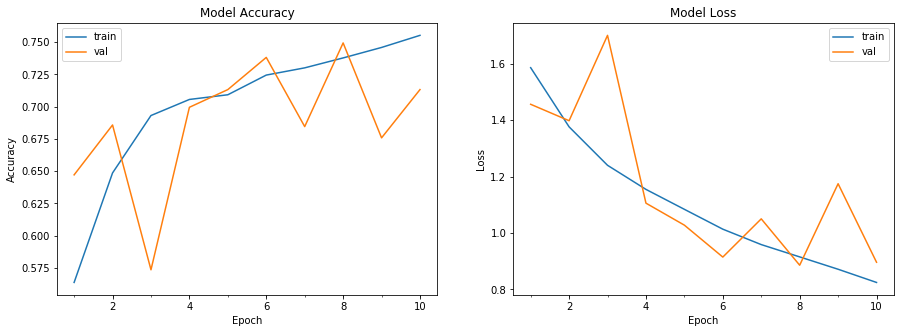

In [37]:
plot_model_history(history)

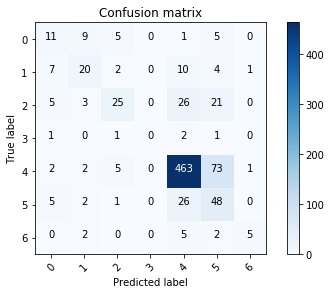

In [38]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = AlexNet.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0,0.5,'Fraction classified incorrectly')

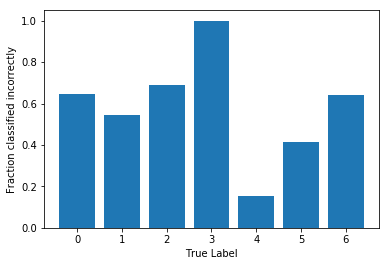

In [39]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')